In [1]:
#@title Install
!pip install git+git://github.com/nielsrolf/ddsp@discriminator tensorflow_addons &> /dev/null

In [2]:
#@title #Mount drive or sync s3
import getpass
import os

#@markdown If you sync an s3 bucket, you will be asked for access key id and secret access key
sync_s3 = False #@param{type:"boolean"}
mount_gdrive = True #@param{type:"boolean"}


if sync_s3:
    results_dir = "s3"
    s3_bucket = "s3://niels-warncke-experiments"
    !pip install awscli &> /dev/null
    os.makedirs("/root/.aws", exist_ok=True)
    with open("/root/.aws/credentials", "w") as private_key:
        print("aws_access_key_id")
        private_key.write(f"[default]\naws_access_key_id = {getpass.getpass()}\n")
        print("aws_secret_access_key")
        private_key.write(f"aws_secret_access_key = {getpass.getpass()}\n")
    !aws s3 sync {s3_bucket} {results_dir} > /dev/null && rm -r /root/.aws
    os.environ["URMP_MONO"] = "s3/urmp-mono/*"
    os.environ["RESULTS_DIR"] = "s3/models"
if mount_gdrive:
    from google.colab import drive
    os.environ['URMP_MONO'] = "drive/MyDrive/ddsp/urmp-mono/*"
    os.environ['results_dir'] = 'drive/MyDrive/ddsp/models'
    drive.mount('/content/drive')
    #@markdown (ex. `/content/drive/MyDrive/...`) 
    DRIVE_DIR = 'drive/MyDrive/ddsp' #@param {type: "string"}
    assert os.path.exists(DRIVE_DIR)
    print('Drive Folder Exists:', DRIVE_DIR)
    results_dir = DRIVE_DIR

Mounted at /content/drive
Drive Folder Exists: drive/MyDrive/ddsp


# RnnDiscriminator


In [104]:
from ddsp import core
from ddsp.training import nn, preprocessing
import gin
import tensorflow.compat.v2 as tf
from tensorflow.keras.layers import Conv1D, ZeroPadding1D
import tensorflow_addons as tfa
from ddsp import spectral_ops

from ddsp.training.discriminator import Discriminator

from pdb import set_trace as breakpoint

tfkl = tf.keras.layers
from matplotlib import pyplot as plt
class MfccTimeConstantRnnDiscriminator(Discriminator):
  """Use MFCCs as latent variables, distribute across timesteps."""

  def __init__(self,
               rnn_channels=512,
               rnn_type='gru',
               z_time_steps=250,
               input_keys=['discriminator_audio', 'f0_hz', 'ld_scaled'],
               spectral_op='compute_mfcc',
               **kwargs):
    # make the input key that contains audio the first
    input_keys = sorted(input_keys, key=lambda i: not 'audio' in i)
    if len(input_keys) > 1:
        assert 'audio' not in input_keys[1], "This discriminator only handles a single audio input"
    super().__init__(**kwargs, input_keys=input_keys)
    if z_time_steps not in [63, 125, 250, 500, 1000]:
      raise ValueError(
          '`z_time_steps` currently limited to 63,125,250,500 and 1000')
    self.z_audio_spec = {
        '63': {
            'fft_size': 2048,
            'overlap': 0.5
        },
        '125': {
            'fft_size': 1024,
            'overlap': 0.5
        },
        '250': {
            'fft_size': 1024,
            'overlap': 0.75
        },
        '500': {
            'fft_size': 512,
            'overlap': 0.75
        },
        '1000': {
            'fft_size': 256,
            'overlap': 0.75
        }
    }
    self.fft_size = self.z_audio_spec[str(z_time_steps)]['fft_size']
    self.spectral_op = spectral_op
    self.overlap = self.z_audio_spec[str(z_time_steps)]['overlap']

    # Layers.
    self.z_norm = nn.Normalize('layer')
    self.rnn = nn.Rnn(rnn_channels, rnn_type)
    self.dense_out = tfkl.Dense(1)
    self.confidence = tfkl.Dense(1)

  def call(self, audio, *conditioning):
    if self.spectral_op == 'compute_mfcc':
        z = spectral_ops.compute_mfcc(
            audio,
            lo_hz=20.0,
            hi_hz=8000.0,
            fft_size=self.fft_size,
            mel_bins=128,
            mfcc_bins=30,
            overlap=self.overlap,
            pad_end=True)
    else:
        z = spectral_ops.compute_logmag(core.tf_float32(audio), size=self.fft_size)
    
    # Normalize.
    z = self.z_norm(z[:, :, tf.newaxis, :])[:, :, 0, :]
    try:
        plt.imshow(z[0].numpy().T)
        plt.show()
        jupyter_utils.show_audio(audio[0])
    except: pass    
    n_timesteps = z.shape[1]
    conditioning = [resample(c, n_timesteps) for c  in conditioning]
    
    z = tf.concat([z] + conditioning, axis=-1)
    # Run an RNN over the latents.
    z = self.rnn(z)
    # Bounce down to compressed z dimensions.
    z = self.dense_out(z)
    return tf.reduce_mean(z, axis=1)
    w = tf.math.sigmoid(self.confidence(z))
    z = self.dense_out(z)
    z = tf.reduce_sum(z * w, axis=1, keepdims=True) / tf.reduce_sum(w, axis=1, keepdims=True)
    return z

In [52]:
tf.__version__

'2.4.1'

# Trainer to train only D

In [72]:
import time

from absl import logging
from ddsp.training import train_util
import gin
import tensorflow.compat.v2 as tf
from ddsp.losses import mean_difference


class Trainer(object):
    """Class to bind an optimizer, model, strategy, and training step function."""

    def __init__(self,
                 model,
                 strategy,
                 checkpoints_to_keep=2,
                 learning_rate_g=0.001,
                 learning_rate_d=0.0002,
                 lr_decay_steps=10000,
                 lr_decay_rate=0.98,
                 grad_clip_norm=3.0,
                 restore_keys=None):
        """Constructor.

        Args:
            model: Model to train.
            strategy: A distribution strategy.
            checkpoints_to_keep: Max number of checkpoints before deleting oldest.
            learning_rate: Scalar initial learning rate.
            lr_decay_steps: Exponential decay timescale.
            lr_decay_rate: Exponential decay magnitude.
            grad_clip_norm: Norm level by which to clip gradients.
            restore_keys: List of names of model properties to restore. If no keys are
                passed, restore the whole model.
        """
        self.model = model
        self.strategy = strategy
        self.checkpoints_to_keep = checkpoints_to_keep
        self.grad_clip_norm = grad_clip_norm
        self.restore_keys = restore_keys

        # Create an optimizer.
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=learning_rate_g,
                decay_steps=lr_decay_steps,
                decay_rate=lr_decay_rate)

        if self.model.is_gan:
            d_lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=learning_rate_d,
                    decay_steps=lr_decay_steps,
                    decay_rate=lr_decay_rate) # TODO correct learning schedule + optimizer?

        with self.strategy.scope():
            optimizer = tf.keras.optimizers.Adam(lr_schedule)
            self.optimizer = optimizer
            if self.model.is_gan:
                d_optimizer = tf.keras.optimizers.Adam(d_lr_schedule)
                self.d_optimizer = d_optimizer

    def save(self, save_dir):
        """Saves model and optimizer to a checkpoint."""
        # Saving weights in checkpoint format because saved_model requires
        # handling variable batch size, which some synths and effects can't.
        start_time = time.time()
        checkpoint = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)
        manager = tf.train.CheckpointManager(
                checkpoint, directory=save_dir, max_to_keep=self.checkpoints_to_keep)
        step = self.step.numpy()
        manager.save(checkpoint_number=step)
        logging.info('Saved checkpoint to %s at step %s', save_dir, step)
        logging.info('Saving model took %.1f seconds', time.time() - start_time)

    def restore(self, checkpoint_path, restore_keys=None):
        """Restore model and optimizer from a checkpoint if it exists."""
        logging.info('Restoring from checkpoint...')
        start_time = time.time()

        # Prefer function args over object properties.
        restore_keys = self.restore_keys if restore_keys is None else restore_keys
        if restore_keys is None:
            # If no keys are passed, restore the whole model.
            model = self.model
            logging.info('Trainer restoring the full model')
        else:
            # Restore only sub-modules by building a new subgraph.
            restore_dict = {k: getattr(self.model, k) for k in restore_keys}
            model = tf.train.Checkpoint(**restore_dict)

            logging.info('Trainer restoring model subcomponents:')
            for k, v in restore_dict.items():
                log_str = 'Restoring {}: {}'.format(k, v)
                logging.info(log_str)

        # Restore from latest checkpoint.
        checkpoint = tf.train.Checkpoint(model=model, optimizer=self.optimizer)
        latest_checkpoint = train_util.get_latest_chekpoint(checkpoint_path)
        if latest_checkpoint is not None:
            # checkpoint.restore must be within a strategy.scope() so that optimizer
            # slot variables are mirrored.
            with self.strategy.scope():
                if restore_keys is None:
                    checkpoint.restore(latest_checkpoint)
                else:
                    checkpoint.restore(latest_checkpoint).expect_partial()
                logging.info('Loaded checkpoint %s', latest_checkpoint)
            logging.info('Loading model took %.1f seconds', time.time() - start_time)
        else:
            logging.info('No checkpoint, skipping.')

    @property
    def step(self):
        """The number of training steps completed."""
        return self.optimizer.iterations

    def psum(self, x, axis=None):
        """Sum across processors."""
        return self.strategy.reduce(tf.distribute.ReduceOp.SUM, x, axis=axis)

    def run(self, fn, *args, **kwargs):
        """Distribute and run function on processors."""
        return self.strategy.run(fn, args=args, kwargs=kwargs)

    def build(self, batch):
        """Build the model by running a distributed batch through it."""
        logging.info('Building the model...')
        _ = self.run(self.model.__call__, batch)
        self.model.summary()

    def distribute_dataset(self, dataset):
        """Create a distributed dataset."""
        if isinstance(dataset, tf.data.Dataset):
            return self.strategy.experimental_distribute_dataset(dataset)
        else:
            return dataset

    @tf.function
    def train_step(self, inputs):
        """Distributed training step."""
        # Wrap iterator in tf.function, slight speedup passing in iter vs batch.
        batch = next(inputs) if hasattr(inputs, '__next__') else inputs
        losses = self.run(self.step_fn, batch)
        # Add up the scalar losses across replicas.
        n_replicas = self.strategy.num_replicas_in_sync
        return {k: self.psum(v, axis=None) / n_replicas for k, v in losses.items()}
    
    @tf.function
    def discriminator_step_fn(self, batch):
        """At this point, the batch already contains the generator output.
        The samples in batch['audio'] and batch['audio_synth'] correspond to each other.
        In order to prevent overfitting on a pattern that is realistic by itself but 
        different from the original sample, it is randomly sampled wether to use the 
        original or synthesized version of a sample.
        """
        losses = {}
        
        real_batch = dict(**batch)
        real_batch['discriminator_audio'] = real_batch['audio']
        fake_batch = dict(**batch)
        fake_batch['discriminator_audio'] = fake_batch['audio_synth']
        
        with tf.GradientTape() as tape:
            scores_real = self.model.discriminator(real_batch)['score']
            scores_fake = self.model.discriminator(fake_batch)['score']
            d = tf.reduce_mean(tf.abs(real_batch['discriminator_audio']) -  fake_batch['discriminator_audio'])
            losses['discriminator_loss_total'] = tf.reduce_mean(scores_real) - tf.reduce_mean(scores_fake)
            # losses['discriminator_loss_real'] = tf.reduce_mean(tf.keras.losses.mean_squared_error(tf.ones_like(scores_real), scores_real))
            # losses['discriminator_loss_fake'] = tf.reduce_mean(tf.keras.losses.mean_squared_error(tf.zeros_like(scores_fake), scores_fake))
            # losses['discriminator_loss_total'] = losses['discriminator_loss_real'] + losses['discriminator_loss_fake']
            losses['discriminator_pred_real'] = tf.reduce_mean(scores_real)
            losses['discriminator_pred_fake'] = tf.reduce_mean(scores_fake)
            losses['difference_input'] = d
            losses['std_synth'] = tf.math.reduce_std(fake_batch['discriminator_audio'])
            losses['std_real'] = tf.math.reduce_std(real_batch['discriminator_audio'])
            grads = tape.gradient(losses['discriminator_loss_total'], self.model.discriminator_variables)
        
        return losses, grads

    @tf.function
    def discriminator_step_fn_(self, batch):
        """At this point, the batch already contains the generator output.
        The samples in batch['audio'] and batch['audio_synth'] correspond to each other.
        In order to prevent overfitting on a pattern that is realistic by itself but 
        different from the original sample, it is randomly sampled wether to use the 
        original or synthesized version of a sample.
        """
        outputs = {}
        use_real_sample = tf.round(tf.random.uniform([batch['audio'].shape[0], 1], maxval=1))
        batch = dict(**batch)
        batch['discriminator_audio'] = use_real_sample * batch['audio'] + (1 - use_real_sample) * batch['audio_synth']
        use_real_sample = tf.squeeze(use_real_sample)
        with tf.GradientTape() as tape:
            scores = self.model.discriminator(batch)['score']
            outputs['discriminator_loss'] = mean_difference(use_real_sample, scores, 'L2')
        mean_pred_real = tf.reduce_sum(scores * use_real_sample) / tf.reduce_sum(use_real_sample)
        mean_pred_synth = tf.reduce_sum(scores * (1 - use_real_sample)) / tf.reduce_sum(1 - use_real_sample)
        grads = tape.gradient(outputs['discriminator_loss'], self.model.discriminator_variables)
        losses = {
            'discriminator_loss': outputs['discriminator_loss'],
            'mean_pred_real': mean_pred_real,
            'mean_pred_synth': mean_pred_synth,
            'j': mean_pred_real-mean_pred_synth }

        return losses, grads

    @tf.function
    def step_fn(self, batch):
        """
        Train only the discriminator
        Per-Replica training step."""
        outputs = self.model(batch)
        d_losses, grads = self.discriminator_step_fn(outputs)
        grads, _ = tf.clip_by_global_norm(grads, self.grad_clip_norm)
        self.d_optimizer.apply_gradients(zip(grads, self.model.discriminator_variables))
        return d_losses

# Discriminator tests and debugging


## Load the data

False
audio (16, 64000)
f0_confidence (16, 1000)
f0_hz (16, 1000)
loudness_db (16, 1000)


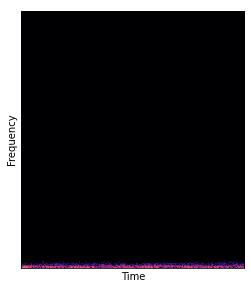

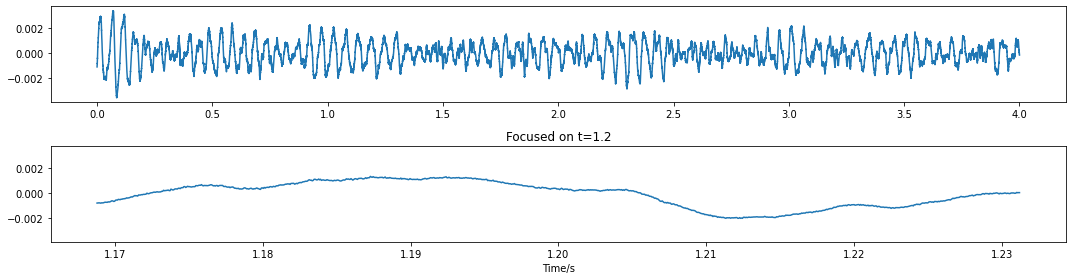

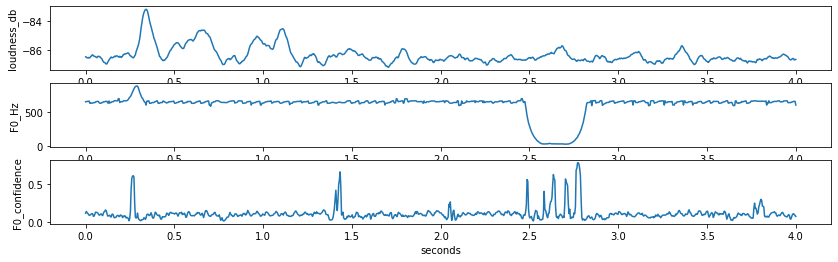

In [5]:
%load_ext autoreload
%autoreload 2

from ddsp.colab import jupyter_utils
import ddsp.training
from matplotlib import pyplot as plt
import numpy as np
import os

TRAIN_TFRECORD_FILEPATTERN = os.environ.get("URMP_MONO")
data_provider = ddsp.training.data.TFRecordProvider(TRAIN_TFRECORD_FILEPATTERN)
print(data_provider is ddsp.training.data.DataProvider)
dataset = data_provider.get_batch(16)

for i in iter(dataset):
    for k, v in i.items():
        print(k, v.shape)
    break

try:
    ex = next(iter(dataset))
except StopIteration:
    raise ValueError(
        'TFRecord contains no examples. Please try re-running the pipeline with '
        'different audio file(s).')

ex = next(iter(dataset))
jupyter_utils.show_audio(ex['audio'][0])

f, ax = plt.subplots(3, 1, figsize=(14, 4))
x = np.linspace(0, 4.0, 1000)
ax[0].set_ylabel('loudness_db')
ax[0].plot(x, ex['loudness_db'][0])
ax[1].set_ylabel('F0_Hz')
ax[1].set_xlabel('seconds')

ax[1].plot(x, ex['f0_hz'][0])
ax[2].set_ylabel('F0_confidence')
ax[2].set_xlabel('seconds')
ax[2].plot(x, ex['f0_confidence'][0])

# Generate training data

We will train on something where the generator outputs random noise as audio vs real audio

In [9]:
from ddsp.synths import TensorToAudio


# Init Model and train

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


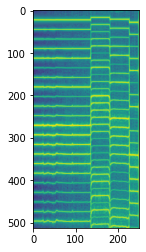

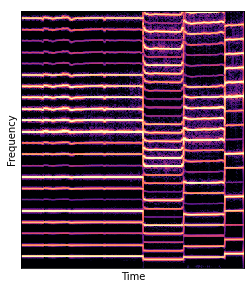

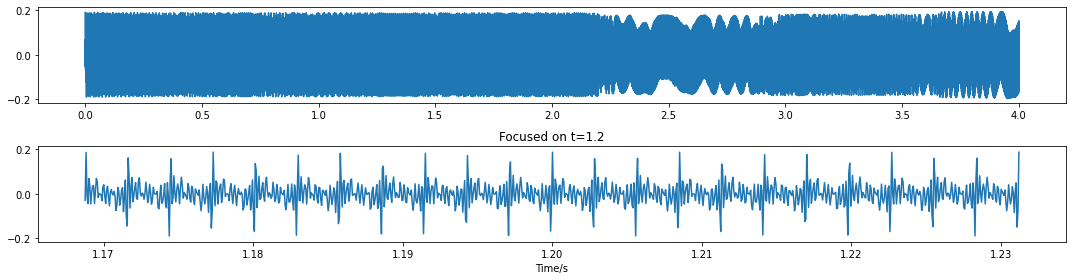

Model: "autoencoder_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
f0_loudness_preprocessor_33  multiple                  0         
_________________________________________________________________
mfcc_time_constant_rnn_encod multiple                  844365    
_________________________________________________________________
rnn_fc_decoder_20 (RnnFcDeco multiple                  1081179   
_________________________________________________________________
processor_group (ProcessorGr multiple                  0         
_________________________________________________________________
mfcc_time_constant_rnn_discr multiple                  1579011   
Total params: 3,504,555
Trainable params: 3,504,555
Non-trainable params: 0
_________________________________________________________________
yo
step: 0	discriminator_loss_total: 0.92	discriminator_pred_real: 0.62	discriminator_pred_fake: -0.30	diffe

In [105]:
%reload_ext tensorboard
import tensorboard as tb
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                                                     train_util, discriminator)
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from ddsp.synths import TensorToAudio


SAVE_DIR = "artifacts/tmp"

# tb.notebook.start('--logdir "{}"'.format(SAVE_DIR))

gin.enter_interactive_mode()

sample_rate = 16000
n_samples = 4*sample_rate

strategy = train_util.get_strategy()

use_real_data = True

with strategy.scope():
    TIME_STEPS = 1000

    # Create Neural Networks.
    preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

    if use_real_data:

        decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                        rnn_type = 'gru',
                                        ch = 256,
                                        layers_per_stack = 1,
                                        input_keys = ('ld_scaled', 'f0_scaled', 'z'),
                                        output_splits = (('amps', 1),
                                                        ('harmonic_distribution', 45),
                                                        ('noise_magnitudes', 45)))

        # Create Processors.
        harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                        sample_rate=sample_rate,
                                        name='harmonic')

        noise = ddsp.synths.FilteredNoise(window_size=0,
                                        initial_bias=-10.0,
                                        name='noise')
        add = ddsp.processors.Add(name='add')

        # Create ProcessorGroup.
        dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
                (noise, ['noise_magnitudes']),
                (add, ['noise/signal', 'harmonic/signal'])]
        encoder = encoders.MfccTimeConstantRnnEncoder(rnn_channels = 512, rnn_type = 'gru', z_dims = 16, z_time_steps = 125)
    else:
        def decoder(features, **kwargs):
            noise = tf.random.normal(features['audio'].shape + [1], 0, 1)
            return dict(bla=noise)

        dag = [(TensorToAudio(), ['bla'])]
        encoder = None
    

    processor_group = ddsp.processors.ProcessorGroup(dag=dag, name='processor_group')

    # encoder = None

    # critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio'], layers=10)
    critic = MfccTimeConstantRnnDiscriminator(input_keys=['discriminator_audio'], spectral_op='compute_logmag')

    model = models.Autoencoder(preprocessor=preprocessor,
                                encoder=encoder,
                                decoder=decoder,
                                processor_group=processor_group,
                                discriminator=critic,
                                losses=[])
    trainer = Trainer(model, strategy, learning_rate_g=1e-3, learning_rate_d=1e-3)
    dataset = trainer.distribute_dataset(dataset)
    trainer.build(next(iter(dataset)))
    print("yo")
    dataset_iter = iter(dataset)
    
    initial_weights_d = [i.numpy() for i in critic.trainable_variables]
    initial_weights_g = [i.numpy() for i in model.generator_variables]

for i in range(20):
    losses = trainer.train_step(dataset_iter)
    updated_weights_d = [i.numpy() for i in critic.trainable_variables]
    updated_weights_g = [i.numpy() for i in model.generator_variables]
    res_str = 'step: {}\t'.format(i)
    for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
    print(res_str)

    if i % 300 == 1:
        print(f"Step {i}")
        trainer.save(SAVE_DIR)

# Randomsss

In [ ]:
getattr(ddsp.spectral_ops, ''

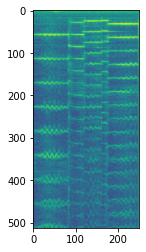

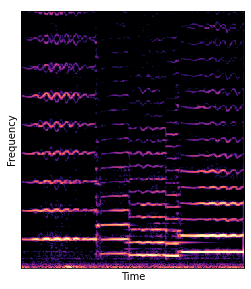

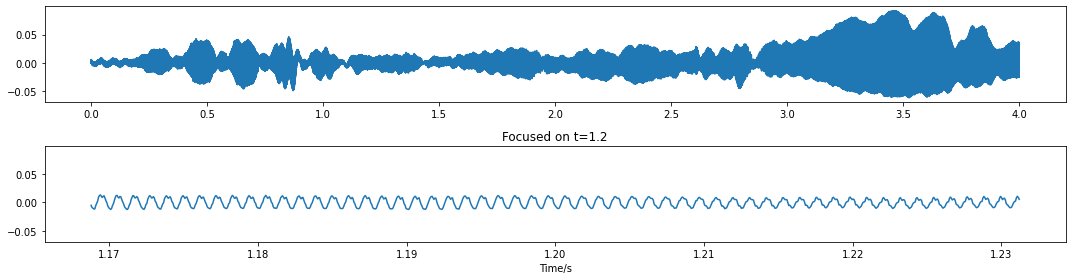

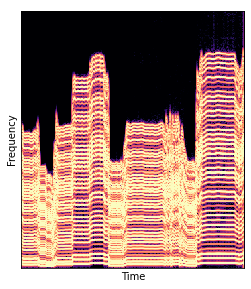

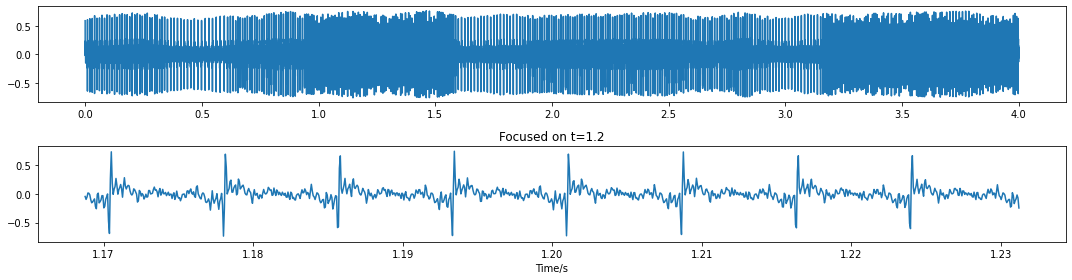

In [98]:
ex = next(dataset_iter)
noise = model(ex)
jupyter_utils.show_audio(noise['audio_synth'][3]
                         )

In [101]:
noise.keys()

dict_keys(['inputs', 'audio', 'f0_confidence', 'f0_hz', 'loudness_db', 'f0_scaled', 'ld_scaled', 'z', 'amps', 'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'noise', 'add', 'out', 'audio_synth'])

In [103]:
critic.input_keys

ListWrapper(['audio'])

In [ ]:
[i-j for i,j in zip(initial_weights_d, updated_weights_d)]

In [86]:
for i in range(100):
    losses = trainer.train_step(dataset_iter)
    updated_weights_d = [i.numpy() for i in critic.trainable_variables]
    updated_weights_g = [i.numpy() for i in model.generator_variables]
    res_str = 'step: {}\t'.format(i)
    for k, v in losses.items():
            res_str += '{}: {:.2f}\t'.format(k, v)
    print(res_str)

step: 0	discriminator_loss_total: 0.00	discriminator_pred_real: 0.50	discriminator_pred_fake: 0.50	difference_input: 0.01	std_synth: 0.04	std_real: 0.02	
step: 1	discriminator_loss_total: 0.00	discriminator_pred_real: 0.96	discriminator_pred_fake: 0.96	difference_input: 0.01	std_synth: 0.04	std_real: 0.02	
step: 2	discriminator_loss_total: 0.00	discriminator_pred_real: 0.60	discriminator_pred_fake: 0.60	difference_input: 0.01	std_synth: 0.03	std_real: 0.02	
step: 3	discriminator_loss_total: 0.00	discriminator_pred_real: 0.60	discriminator_pred_fake: 0.60	difference_input: 0.01	std_synth: 0.03	std_real: 0.02	
step: 4	discriminator_loss_total: 0.00	discriminator_pred_real: 0.68	discriminator_pred_fake: 0.68	difference_input: 0.01	std_synth: 0.03	std_real: 0.02	
step: 5	discriminator_loss_total: 0.00	discriminator_pred_real: 0.65	discriminator_pred_fake: 0.65	difference_input: 0.01	std_synth: 0.03	std_real: 0.02	
step: 6	discriminator_loss_total: 0.00	discriminator_pred_real: 0.72	discrim

KeyboardInterrupt: ignored

In [ ]:
outputs = model(ex)

In [ ]:
critic = discriminator.ParallelWaveGANDiscriminator(input_keys=['discriminator_audio', 'f0_hz', 'loudness_db'])

real = dict(**outputs)
real['discriminator_audio'] = real['audio']
score_real = critic(real)

fake = dict(**outputs)
fake['discriminator_audio'] = real['audio_synth']
score_fake = critic(fake)
score_fake

{'score': <tf.Tensor: shape=(16,), dtype=float32, numpy=
 array([-0.06645617, -0.00907318, -0.03439656, -0.02540755, -0.02198879,
        -0.02219413,  0.10043318,  0.07320849, -0.02789523,  0.01715649,
        -0.02635457, -0.07435222,  0.09247959, -0.01358686, -0.09260409,
        -0.11972335], dtype=float32)>}

In [ ]:
score_real['score']==score_fake['score']

<tf.Tensor: shape=(16,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])>

In [ ]:
test = dict(**outputs)
test['discriminator_audio'] = test['audio_synth']*0
score_test = critic(test)

score_test['score']==score_fake['score']

<tf.Tensor: shape=(16,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])>

In [ ]:
score_fake['score'].numpy() - score_real['score'].numpy()

array([-1.3142824e-05, -3.1292439e-05, -6.1392784e-06, -5.1558018e-06,
       -3.7550926e-06, -1.3023615e-05, -1.6689301e-05, -1.7940998e-05,
        8.0466270e-07, -8.1658363e-06, -6.3568354e-05,  6.6757202e-06,
       -5.3346157e-06,  8.3446503e-07,  1.6272068e-05,  1.4811754e-05],
      dtype=float32)

In [ ]:
score_fake['score'].numpy()

array([0.47820702, 0.36534688, 0.60997313, 0.37323377, 0.64212334,
       0.4302551 , 0.4660166 , 0.3548955 , 0.44292516, 0.50246805,
       0.36433265, 0.36701378, 0.40276808, 0.48888817, 0.439849  ,
       0.46455997], dtype=float32)